# About merged otu table

Attempt to describe the merged otu table.

In [1]:
import logging

import biom
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src import project_directory
from src.database import get_session, Sample

I can retrieve information reling on the database made with metadata: let's connect to SQLite database and retrieve the information:

In [2]:
session = get_session()
logging.basicConfig()
logging.getLogger('sqlalchemy.engine.Engine').setLevel(logging.ERROR)

In [3]:
biom_file = project_directory / "merged_results/export/table/feature-table.biom"
table = biom.load_table(biom_file)

In [4]:
# Get the list of samples in the OTU table
samples = table.ids(axis='sample')
print(samples[:10])

['H_10_S10_L001' 'H_11_S11_L001' 'H_12_S12_L001' 'H_13_S13_L001'
 'H_14_S14_L001' 'H_15_S15_L001' 'H_16_S16_L001' 'H_17_S17_L001'
 'H_18_S18_L001' 'H_19_S19_L001']


Now select from database relying on sample names: create a dictionary with sample names as keys and tissue as values:

In [5]:
# Query the database for samples in the samples list and collect the tissue
queried_samples = session.query(Sample).filter(Sample.sample_id.in_(samples)).all()
sample2tissue = {sample.sample_id: sample.dataset.tissue for sample in queried_samples}
sample2dataset = {sample.sample_id: sample.dataset.id for sample in queried_samples}

In [6]:
# Create an empty dataframe with the same indices as the samples
metadata = pd.DataFrame(index=samples)

# Add the tissue as new metadata
metadata['tissue'] = metadata.index.map(sample2tissue)
metadata['dataset'] = metadata.index.map(sample2dataset)

# Update the OTU table with the new metadata
table.add_metadata(metadata.to_dict(orient='index'), axis='sample')

# Verify that the tissue has been added correctly
print(table.metadata(axis='sample')[:3])

(defaultdict(<function Table._cast_metadata.<locals>.cast_metadata.<locals>.<lambda> at 0x7fb9c1062550>, {'tissue': 'hindgut', 'dataset': 3}), defaultdict(<function Table._cast_metadata.<locals>.cast_metadata.<locals>.<lambda> at 0x7fb9c10623a0>, {'tissue': 'hindgut', 'dataset': 3}), defaultdict(<function Table._cast_metadata.<locals>.cast_metadata.<locals>.<lambda> at 0x7fb9c1062430>, {'tissue': 'hindgut', 'dataset': 3}))


Let's try to do an heatmap: we have a lot of data, focus only on the most abundant ASVs:

In [7]:
# Convert the biom table to a dense numpy array
data = table.matrix_data.toarray()

# Select the 1000 most abundant rows
row_sums = data.sum(axis=1)
top_1000_indices = np.argsort(row_sums)[-1000:]
top_1000_data = data[top_1000_indices, :]

Create a clustermap for tissue:

/home/paolo/.cache/pypoetry/virtualenvs/deep-micro-core-JiEBGuw_-py3.9/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


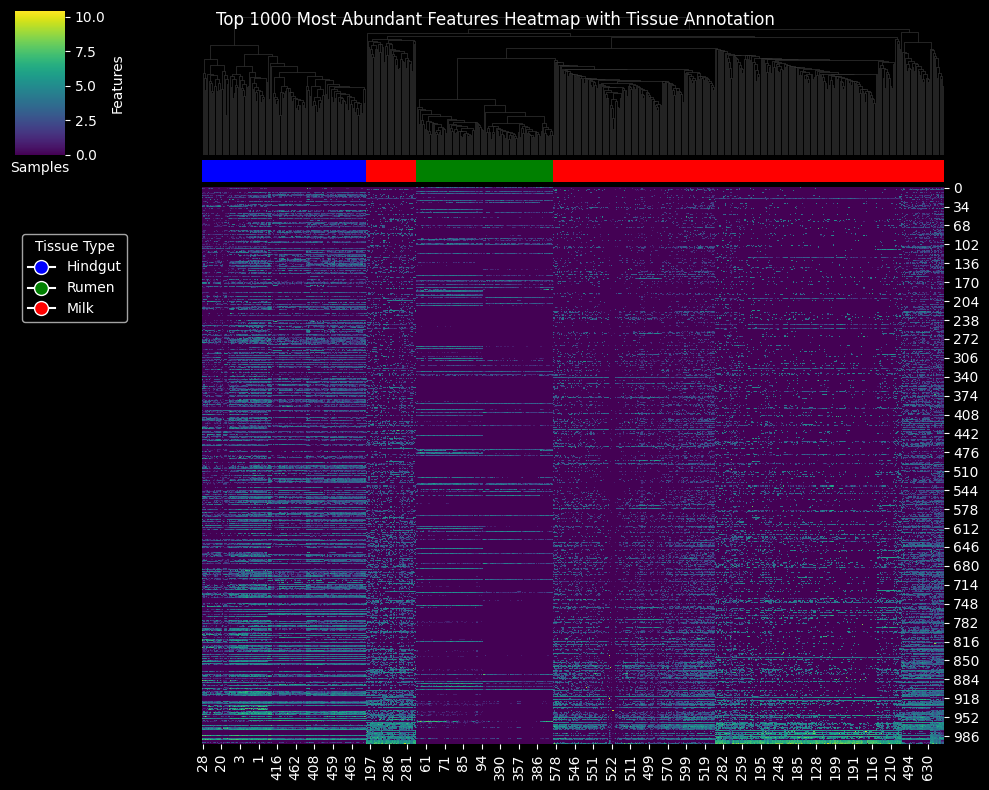

In [8]:
# Create a clustermap with seaborn
sns.clustermap(
    np.log1p(top_1000_data),
    cmap='viridis', 
    figsize=(10, 8), 
    row_cluster=False, 
    col_cluster=True,
    col_colors=metadata['tissue'].map({'hindgut': 'blue', 'rumen': 'green', 'milk': 'red'}).to_numpy(),
)

# Create a custom legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Hindgut', markersize=10, markerfacecolor='blue'),
    plt.Line2D([0], [0], marker='o', color='w', label='Rumen', markersize=10, markerfacecolor='green'),
    plt.Line2D([0], [0], marker='o', color='w', label='Milk', markersize=10, markerfacecolor='red')
]

plt.legend(handles=handles, title='Tissue Type', loc='upper left', bbox_to_anchor=(0, -0.5))

# Add title and labels
plt.suptitle('Top 1000 Most Abundant Features Heatmap with Tissue Annotation', ha='center')
plt.xlabel('Samples')
plt.ylabel('Features')
plt.show()

/home/paolo/.cache/pypoetry/virtualenvs/deep-micro-core-JiEBGuw_-py3.9/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


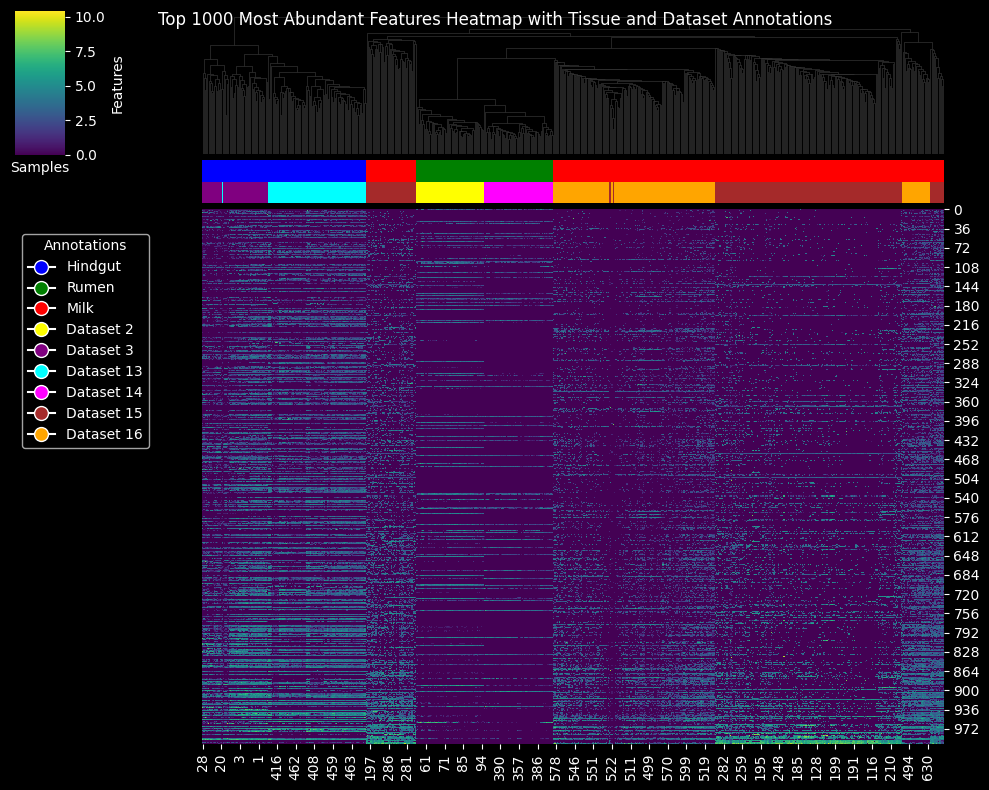

In [9]:
# Create a clustermap with seaborn including both tissue and dataset annotations
sns.clustermap(
    np.log1p(top_1000_data),
    cmap='viridis', 
    figsize=(10, 8), 
    row_cluster=False, 
    col_cluster=True,
    col_colors=[
        metadata['tissue'].map({'hindgut': 'blue', 'rumen': 'green', 'milk': 'red'}).to_numpy(),
        metadata['dataset'].map({2: 'yellow', 3: 'purple', 13: 'cyan', 14: 'magenta', 15: 'brown', 16: 'orange'}).to_numpy()
    ],
)

# Create a custom legend for tissue
tissue_handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Hindgut', markersize=10, markerfacecolor='blue'),
    plt.Line2D([0], [0], marker='o', color='w', label='Rumen', markersize=10, markerfacecolor='green'),
    plt.Line2D([0], [0], marker='o', color='w', label='Milk', markersize=10, markerfacecolor='red')
]

# Create a custom legend for dataset
dataset_handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Dataset 2', markersize=10, markerfacecolor='yellow'),
    plt.Line2D([0], [0], marker='o', color='w', label='Dataset 3', markersize=10, markerfacecolor='purple'),
    plt.Line2D([0], [0], marker='o', color='w', label='Dataset 13', markersize=10, markerfacecolor='cyan'),
    plt.Line2D([0], [0], marker='o', color='w', label='Dataset 14', markersize=10, markerfacecolor='magenta'),
    plt.Line2D([0], [0], marker='o', color='w', label='Dataset 15', markersize=10, markerfacecolor='brown'),
    plt.Line2D([0], [0], marker='o', color='w', label='Dataset 16', markersize=10, markerfacecolor='orange')
]

plt.legend(handles=tissue_handles + dataset_handles, title='Annotations', loc='upper left', bbox_to_anchor=(0, -0.5))

# Add title and labels
plt.suptitle('Top 1000 Most Abundant Features Heatmap with Tissue and Dataset Annotations', ha='center')
plt.xlabel('Samples')
plt.ylabel('Features')
plt.show()

Try to do another clustermap for the most 250 abundant ASVs:

In [10]:
row_sums = data.sum(axis=1)
top_250_indices = np.argsort(row_sums)[-100:]
top_250_data = data[top_250_indices, :]

/home/paolo/.cache/pypoetry/virtualenvs/deep-micro-core-JiEBGuw_-py3.9/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


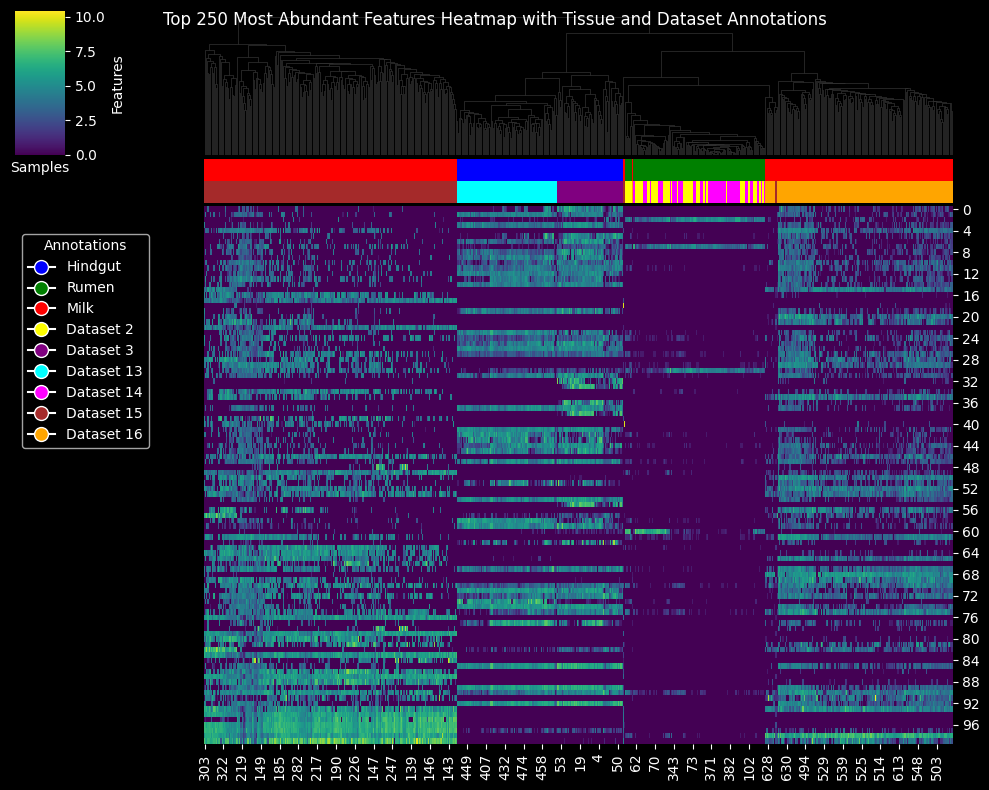

In [11]:
# Create a clustermap with seaborn including both tissue and dataset annotations
sns.clustermap(
    np.log1p(top_250_data),
    cmap='viridis', 
    figsize=(10, 8), 
    row_cluster=False, 
    col_cluster=True,
    col_colors=[
        metadata['tissue'].map({'hindgut': 'blue', 'rumen': 'green', 'milk': 'red'}).to_numpy(),
        metadata['dataset'].map({2: 'yellow', 3: 'purple', 13: 'cyan', 14: 'magenta', 15: 'brown', 16: 'orange'}).to_numpy()
    ],
)

# Create a custom legend for tissue
tissue_handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Hindgut', markersize=10, markerfacecolor='blue'),
    plt.Line2D([0], [0], marker='o', color='w', label='Rumen', markersize=10, markerfacecolor='green'),
    plt.Line2D([0], [0], marker='o', color='w', label='Milk', markersize=10, markerfacecolor='red')
]

# Create a custom legend for dataset
dataset_handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Dataset 2', markersize=10, markerfacecolor='yellow'),
    plt.Line2D([0], [0], marker='o', color='w', label='Dataset 3', markersize=10, markerfacecolor='purple'),
    plt.Line2D([0], [0], marker='o', color='w', label='Dataset 13', markersize=10, markerfacecolor='cyan'),
    plt.Line2D([0], [0], marker='o', color='w', label='Dataset 14', markersize=10, markerfacecolor='magenta'),
    plt.Line2D([0], [0], marker='o', color='w', label='Dataset 15', markersize=10, markerfacecolor='brown'),
    plt.Line2D([0], [0], marker='o', color='w', label='Dataset 16', markersize=10, markerfacecolor='orange')
]

plt.legend(handles=tissue_handles + dataset_handles, title='Annotations', loc='upper left', bbox_to_anchor=(0, -0.5))

# Add title and labels
plt.suptitle('Top 250 Most Abundant Features Heatmap with Tissue and Dataset Annotations', ha='center')
plt.xlabel('Samples')
plt.ylabel('Features')
plt.show()

Try to do a different thing: calculate the clustermap using the correlation matrix between samples (the transpose of the otu table):

/home/paolo/.cache/pypoetry/virtualenvs/deep-micro-core-JiEBGuw_-py3.9/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/paolo/.cache/pypoetry/virtualenvs/deep-micro-core-JiEBGuw_-py3.9/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


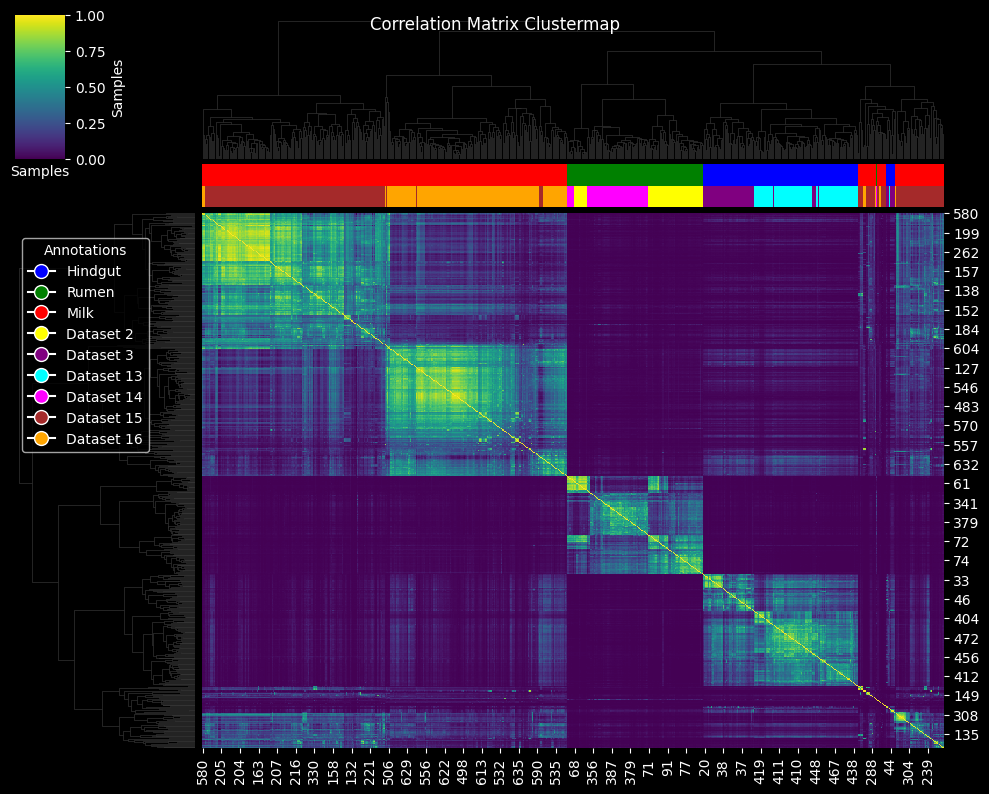

In [12]:
# Compute the correlation matrix
correlation_matrix = np.corrcoef(data.T)

# Create a clustermap with seaborn using the correlation matrix
sns.clustermap(
    correlation_matrix,
    cmap='viridis', 
    figsize=(10, 8), 
    row_cluster=True, 
    col_cluster=True,
    col_colors=[
        metadata['tissue'].map({'hindgut': 'blue', 'rumen': 'green', 'milk': 'red'}).to_numpy(),
        metadata['dataset'].map({2: 'yellow', 3: 'purple', 13: 'cyan', 14: 'magenta', 15: 'brown', 16: 'orange'}).to_numpy()
    ]
)

# Create a custom legend for tissue
tissue_handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Hindgut', markersize=10, markerfacecolor='blue'),
    plt.Line2D([0], [0], marker='o', color='w', label='Rumen', markersize=10, markerfacecolor='green'),
    plt.Line2D([0], [0], marker='o', color='w', label='Milk', markersize=10, markerfacecolor='red')
]

# Create a custom legend for dataset
dataset_handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Dataset 2', markersize=10, markerfacecolor='yellow'),
    plt.Line2D([0], [0], marker='o', color='w', label='Dataset 3', markersize=10, markerfacecolor='purple'),
    plt.Line2D([0], [0], marker='o', color='w', label='Dataset 13', markersize=10, markerfacecolor='cyan'),
    plt.Line2D([0], [0], marker='o', color='w', label='Dataset 14', markersize=10, markerfacecolor='magenta'),
    plt.Line2D([0], [0], marker='o', color='w', label='Dataset 15', markersize=10, markerfacecolor='brown'),
    plt.Line2D([0], [0], marker='o', color='w', label='Dataset 16', markersize=10, markerfacecolor='orange')
]

plt.legend(handles=tissue_handles + dataset_handles, title='Annotations', loc='upper left', bbox_to_anchor=(0, -0.5))


# Add title and labels
plt.suptitle('Correlation Matrix Clustermap', ha='center')
plt.xlabel('Samples')
plt.ylabel('Samples')
plt.show()